## Estimating Bayesian Probabilities with PyMC3
> Today's Bayesian problem of the week: Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are. During the tour, we see 3 lions, 2 tigers, and 1 bear. Assuming that every animal had an equal chance to appear in our sample, estimate the prevalence of each species. What is the probability that the next animal we see is a bear? [tweet link](https://twitter.com/AllenDowney/status/1063460263716892674)


*Ref*: 
- [https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815](https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815)
- [https://github.com/WillKoehrsen/probabilistic-programming/blob/master/Estimating%20Probabilities%20with%20Bayesian%20Inference.ipynb](https://github.com/WillKoehrsen/probabilistic-programming/blob/master/Estimating%20Probabilities%20with%20Bayesian%20Inference.ipynb)


In comparison to frequentist approach where the data completely speak for itself, in a Bayesian framework, we incorporate *priors*. As observations increase, the effect of the priors disappear and we only use the data. We can also alter the weight of priors depending on our confidence in them.

### Model

The overall system is as follows:
1. The underlying model iss a multinomial distribution with parameters $p_k$
2. The prior distribution of $p_k$ is a [Dirichlet Distribution](https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution)
3. The $\alpha$ vector is a parameter of the prior Dirichlet Distribution, hence a hyperparameter

The model can be expressed as the following:

$${\begin{array}{lclcl}{\boldsymbol {\alpha }}&=&(\alpha _{1},\ldots ,\alpha _{K})&=&{\text{concentration hyperparameter}}\\\mathbf {p} \mid {\boldsymbol {\alpha }}&=&(p_{1},\ldots ,p_{K})&\sim &\operatorname {Dir} (K,{\boldsymbol {\alpha }})\\\mathbb {X} \mid \mathbf {p} &=&(x_{1},\ldots ,x_{K})&\sim &\operatorname {Mult} (K,\mathbf {p} )\end{array}}$$

The goal is to find $p_\text{lions}$, $p_\text{tigers}$, $p_\text{bears}$ given the observation vector $c = [c_{lions}, c_{tigers}, c_{bears}]$

In [3]:
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 22
%matplotlib inline

from matplotlib import MatplotlibDeprecationWarning

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

import pymc3 as pm

In [4]:
species = ["lions", "tigers", "bears"]

# Observations
c = np.array([3, 2, 1])

# Pseudocounts 
alphas = np.array([1, 1, 1])

alpha_list = [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]

### Expected Value

$${\displaystyle \operatorname {E} [p_{i}\mid \mathbb {X} ,{\boldsymbol {\alpha }}]={\frac {c_{i}+\alpha _{i}}{N+\sum _{k}\alpha _{k}}}}$$

In [5]:

expected = (alphas + c) / (c.sum() + alphas.sum())

In [6]:
for s, p in zip(species, expected):
    print("Species: {}  Prevalence:{:.2%}".format(s, p))

Species: lions  Prevalence:44.44%
Species: tigers  Prevalence:33.33%
Species: bears  Prevalence:22.22%


In [7]:
# try a few different hyperparameter values
values = []
for alpha_new in alpha_list:
    values.append((alpha_new + c) / (c.sum() + alpha_new.sum()))

value_df = pd.DataFrame(values, columns=species)
value_df["alphas"] = [str(x) for x in alpha_list]
value_df

,lions,tigers,bears,alphas
0,0.492063,0.333333,0.174603,[0.1 0.1 0.1]
1,0.444444,0.333333,0.222222,[1 1 1]
2,0.380952,0.333333,0.285714,[5 5 5]
3,0.352941,0.333333,0.313725,[15 15 15]


In [12]:
melted = pd.melt(value_df, id_vars="alphas", value_name="prevalence", var_name="species")
melted

,alphas,species,prevalence
0,[0.1 0.1 0.1],lions,0.492063
1,[1 1 1],lions,0.444444
2,[5 5 5],lions,0.380952
3,[15 15 15],lions,0.352941
4,[0.1 0.1 0.1],tigers,0.333333
5,[1 1 1],tigers,0.333333
6,[5 5 5],tigers,0.333333
7,[15 15 15],tigers,0.333333
8,[0.1 0.1 0.1],bears,0.174603
9,[1 1 1],bears,0.222222


Text(0.5, 1.0, 'Expected Value')

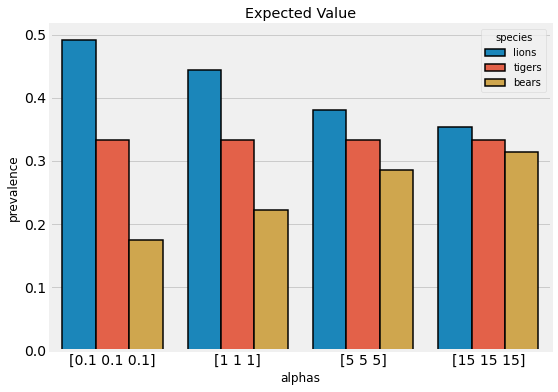

In [14]:
plt.figure(figsize = (8, 6))
sns.barplot(x="alphas", y="prevalence", hue="species", data=melted, edgecolor="k", linewidth=1.5)
plt.xticks(size=14); plt.yticks(size=14); 
plt.title("Expected Value")

### Bayesian Model
We are using a multinomial as our model, a Dirichlet distribution as the prior, and a specified hyperparameter vector. The objective is to find the parameters of the multinomial, $p_k$ which are the probability of each species given the evidence.

$$(\mathbf {p} \mid \mathbb  {X}, {\boldsymbol {\alpha}})$$

To solve the problem, we'll build a model in PyMC3 and then use a variant of Markov Chain Monte Carlo (the No-UTurn Sampler specifically) to draw samples from the posterior. With enough samples, the estimate will converge on the true posterior. Along with single point estimates (such as the mean of sampled values), MCMC also gives us built in uncertainty because we get thousands of possible values from the posterior.

In [16]:
with pm.Model() as model:
    # Parameters of the Multinomial are from a Dirichlet
    parameters = pm.Dirichlet("parameters", a=alphas, shape=3)
    # Observed data is from a Multinomial distribution 
    observed_data = pm.Multinomial(
        "observed_data", n=6, p=parameters, shape=3, observed=c
    )

In [17]:
model

### Sampling from the Model
The cell below samples 1000 draws from the posterior in 2 chains. We use 500 samples for tuning which are discarded. This means that for each random variable in the model - the `parameters` - we will have 2000 values drawn from the posterior distribution


In [19]:
with model:
    # sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.


### Inspecting Results

In [22]:
summary = pm.summary(trace)
summary.index = species
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lions,0.440,0.158,0.171,0.746,0.004,0.003,1203.0,1047.0,1.0
tigers,0.338,0.154,0.074,0.619,0.004,0.003,1305.0,1171.0,1.0
bears,0.222,0.130,0.013,0.452,0.003,0.003,1585.0,1467.0,1.0


In [28]:
# samples
trace_df = pd.DataFrame(trace["parameters"], columns=species)
trace_df.head()

,lions,tigers,bears
0,0.509016,0.290345,0.200639
1,0.332137,0.314766,0.353097
2,0.332137,0.314766,0.353097
3,0.483818,0.253877,0.262305
4,0.378483,0.528350,0.093167


In [29]:
trace_df.shape

(2000, 3)

In [34]:
pvals = trace_df.mean()
pvals

lions     0.440109
tigers    0.337572
bears     0.222319
dtype: float64

In [37]:
summary.iloc[:, 2:4]

,hdi_3%,hdi_97%
lions,0.171,0.746
tigers,0.074,0.619
bears,0.013,0.452


### Diagnostic Plots

#### Posterior Plot

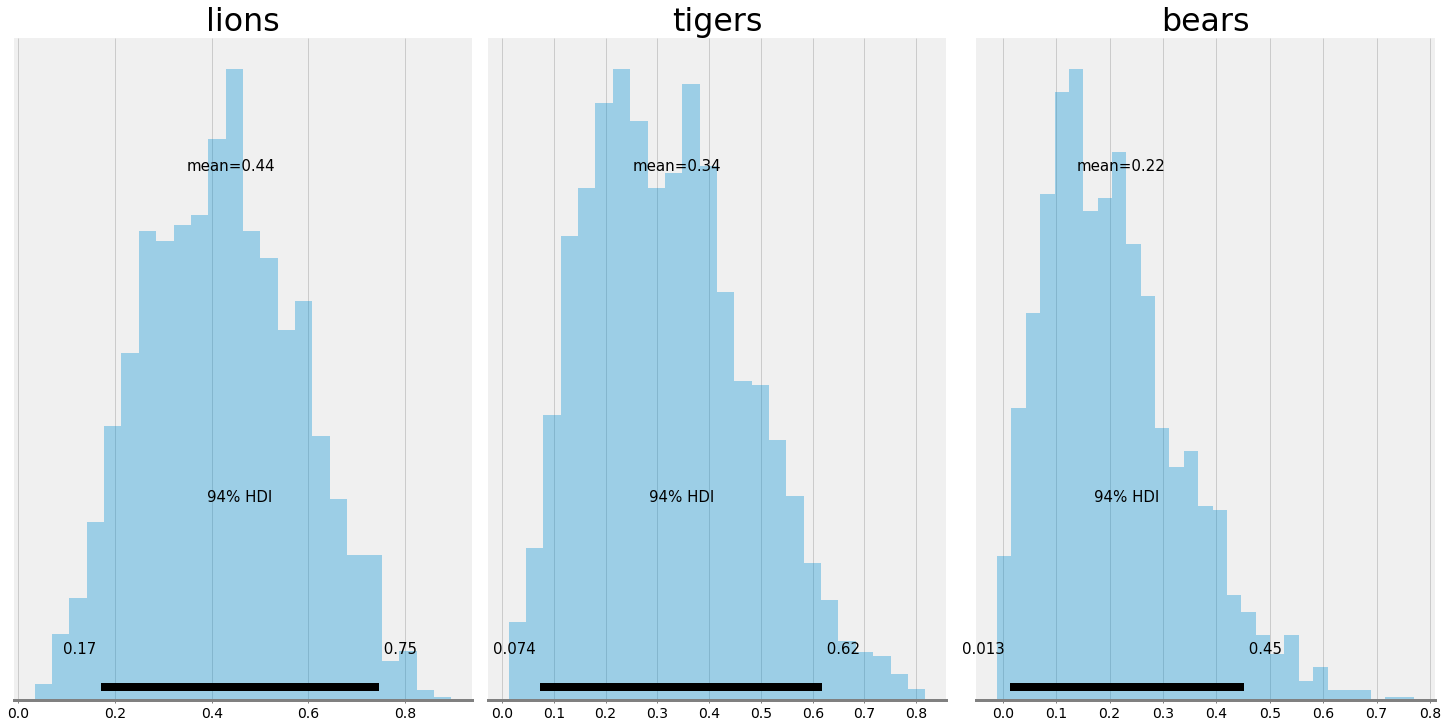

In [55]:
ax = pm.plot_posterior(trace, var_names = ["parameters"], 
                       figsize = (20, 10), kind="hist");

plt.rcParams["font.size"] = 22
for i, a in enumerate(species):
    ax[i].set_title(a);

#### Traceplot
The traceplot shows a kernel density estimate (a smoothed histogram) on the left and all the samples that were drawn on the right. We collapse the chains on th plots (`combined = True`) but in reality we drew 2 independent chains.

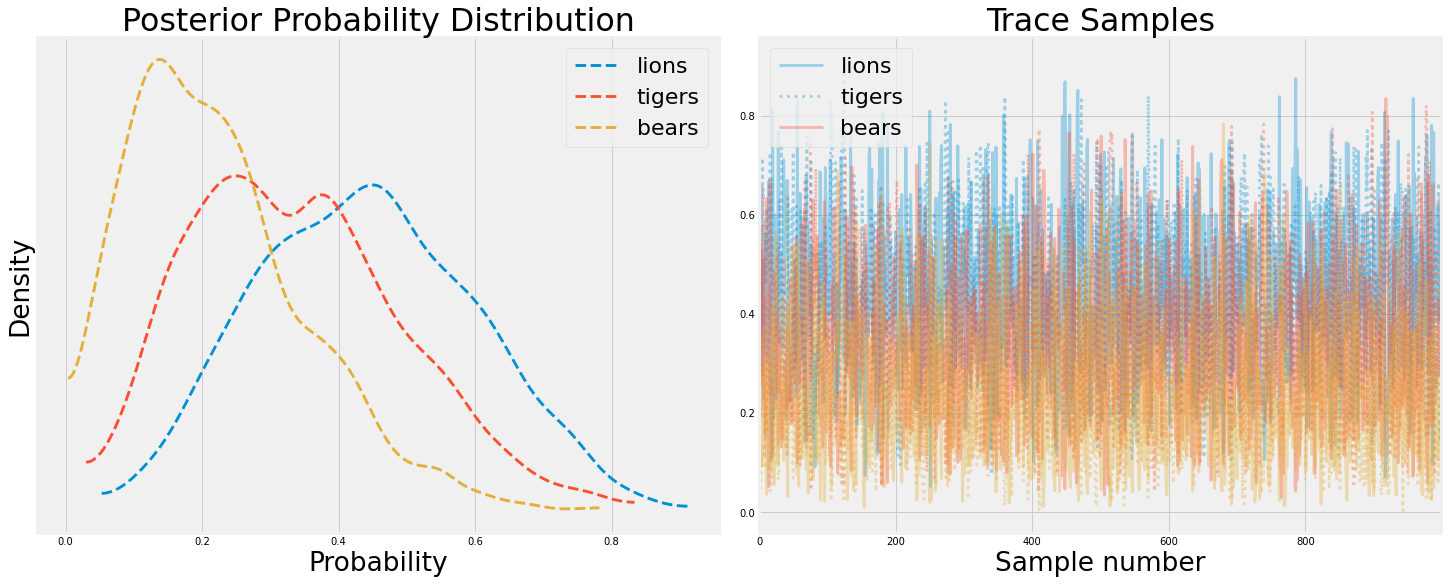

In [71]:
prop_cycle = plt.rcParams["axes.prop_cycle"]
cs = [x["color"] for x in list(prop_cycle)]

ax = pm.plot_trace(trace, var_names = ["parameters"], figsize = (20, 8), combined = True);
ax[0][0].set_title("Posterior Probability Distribution"); ax[0][1].set_title("Trace Samples");
ax[0][0].set_xlabel("Probability"); ax[0][0].set_ylabel("Density")
ax[0][1].set_xlabel("Sample number")
ax[0][0].legend(species)
ax[0][1].legend(species);

### More Observations
If we have additional observations, more trips to the preserve, we can easily do the sampling taking into account this data

In [87]:
c = np.array([[3, 2, 1],
              [2, 3, 1],
              [3, 2, 1],
              [2, 3, 1]])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet("parameters", a=alphas, shape=3)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial(
        "observed_data", n=6, p=parameters, shape=3, observed=c)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.


In [82]:
summary = pm.summary(trace)
summary.index = species
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lions,0.407,0.092,0.243,0.580,0.002,0.002,1652.0,1351.0,1.0
tigers,0.407,0.092,0.236,0.578,0.002,0.002,1684.0,1282.0,1.0
bears,0.186,0.073,0.064,0.319,0.002,0.001,1644.0,1602.0,1.0


The uncertainty of the prevalence of bears has decreased and the prevalence of the lions and tigers is nearly identical as expected from the data. As we gather more data, we can incorporate it into the model to get more accurate estimates. A larger amount of data will mean less uncertainty in the sampling as well.

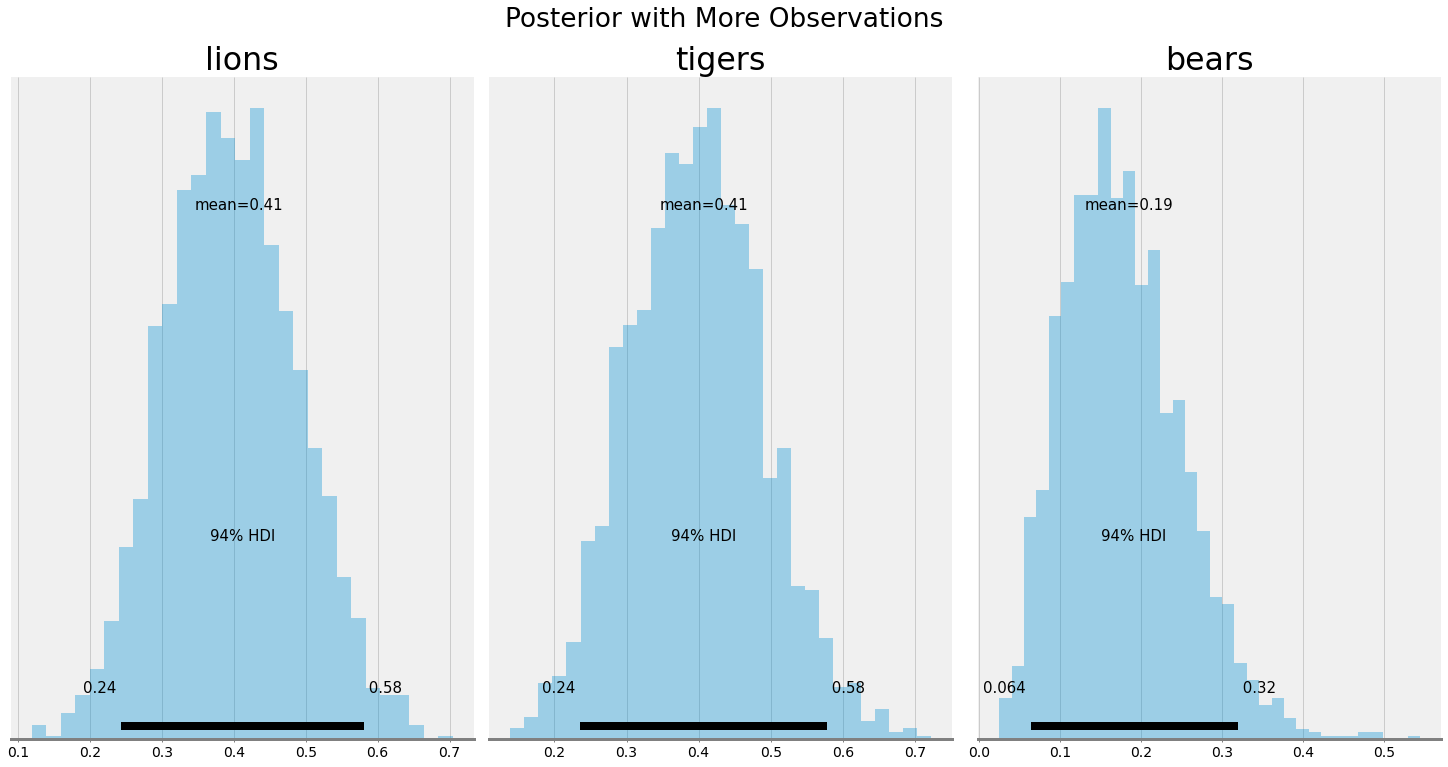

In [86]:
ax = pm.plot_posterior(trace, var_names = ["parameters"], 
                       figsize = (20, 10), kind="hist");

plt.rcParams["font.size"] = 22
for i, a in enumerate(species):
    ax[i].set_title(a);
    
plt.suptitle("Posterior with More Observations", y = 1.05);

### Increasing/Decreasing Confidence in Hyperparameters

In [88]:
c = np.array([3, 2, 1])

def sample_with_priors(alphas):
    with pm.Model() as model:
        # Parameters are a dirichlet distribution
        parameters = pm.Dirichlet("parameters", a=alphas, shape=3)
        # Observed data is a multinomial distribution
        observed_data = pm.Multinomial(
            "observed_data", n=6, p=parameters, shape=3, observed=c)    
        
        trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)
    return trace

In [89]:
trace_dict = {}

for alpha_array in [np.array([0.1, 0.1, 0.1]), 
                    np.array([1, 1, 1]),
                    np.array([5, 5, 5]), 
                    np.array([15, 15, 15])]:
    trace_dict[str(alpha_array[0])] = sample_with_priors(alpha_array)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.


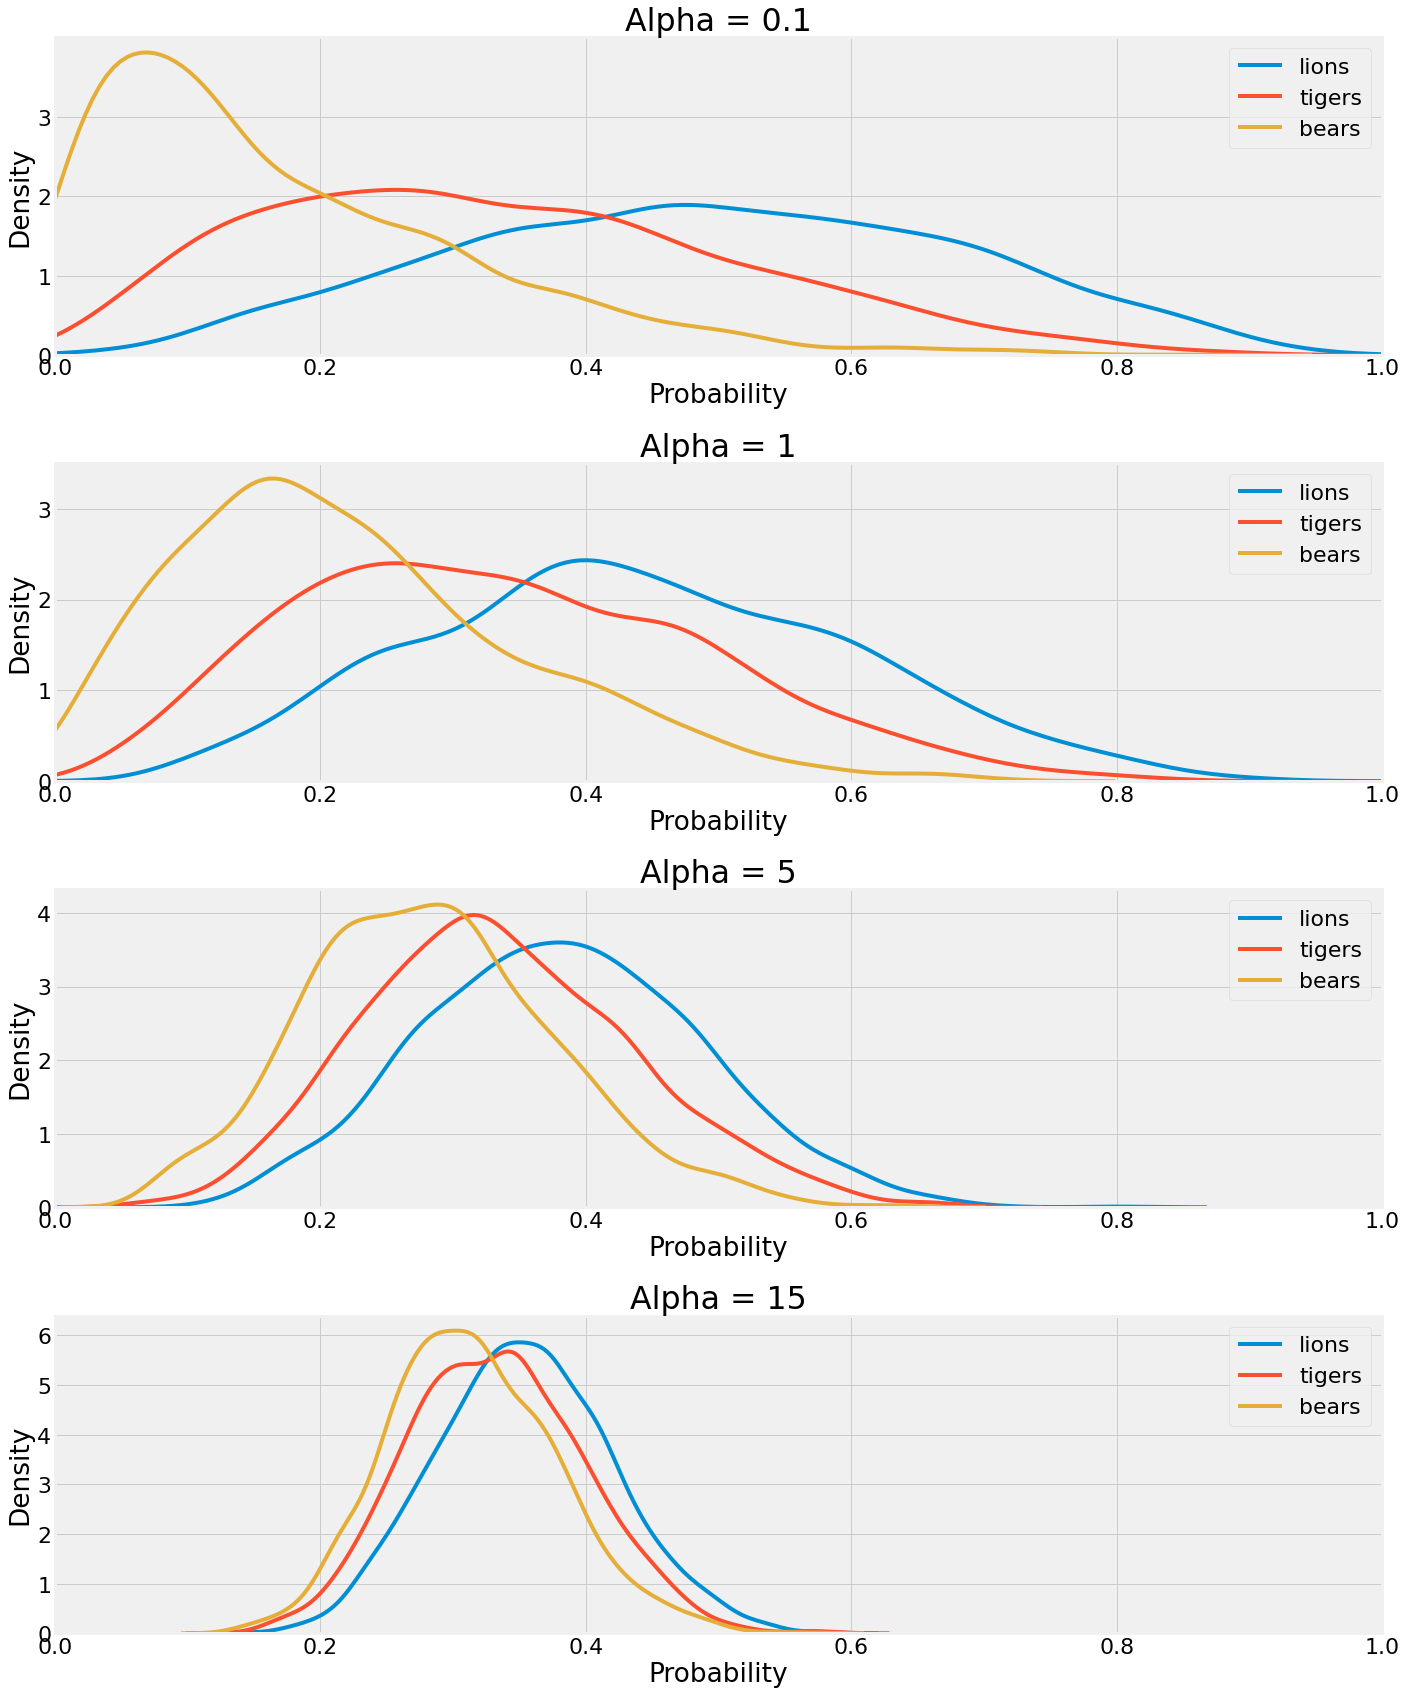

In [90]:
plt.figure(figsize = (20, 24))

for ii, (alpha, trace) in enumerate(trace_dict.items()):
    plt.subplot(4, 1, ii + 1)
    array = trace["parameters"]
    for jj, animal in enumerate(species):
        sns.kdeplot(array[:, jj], label = f'{animal}')
    plt.legend();
    plt.xlabel("Probability"); plt.ylabel("Density")
    plt.title(f"Alpha = {alpha}");
    plt.xlim((0, 1));
    
plt.tight_layout();
plt.show();

In [92]:
prior = '1'
trace = trace_dict[prior]
summary = pm.summary(trace)
summary.index = species
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lions,0.440,0.160,0.144,0.734,0.005,0.003,1076.0,849.0,1.0
tigers,0.338,0.154,0.064,0.612,0.004,0.003,1220.0,1186.0,1.0
bears,0.222,0.130,0.006,0.452,0.003,0.002,1482.0,1029.0,1.0


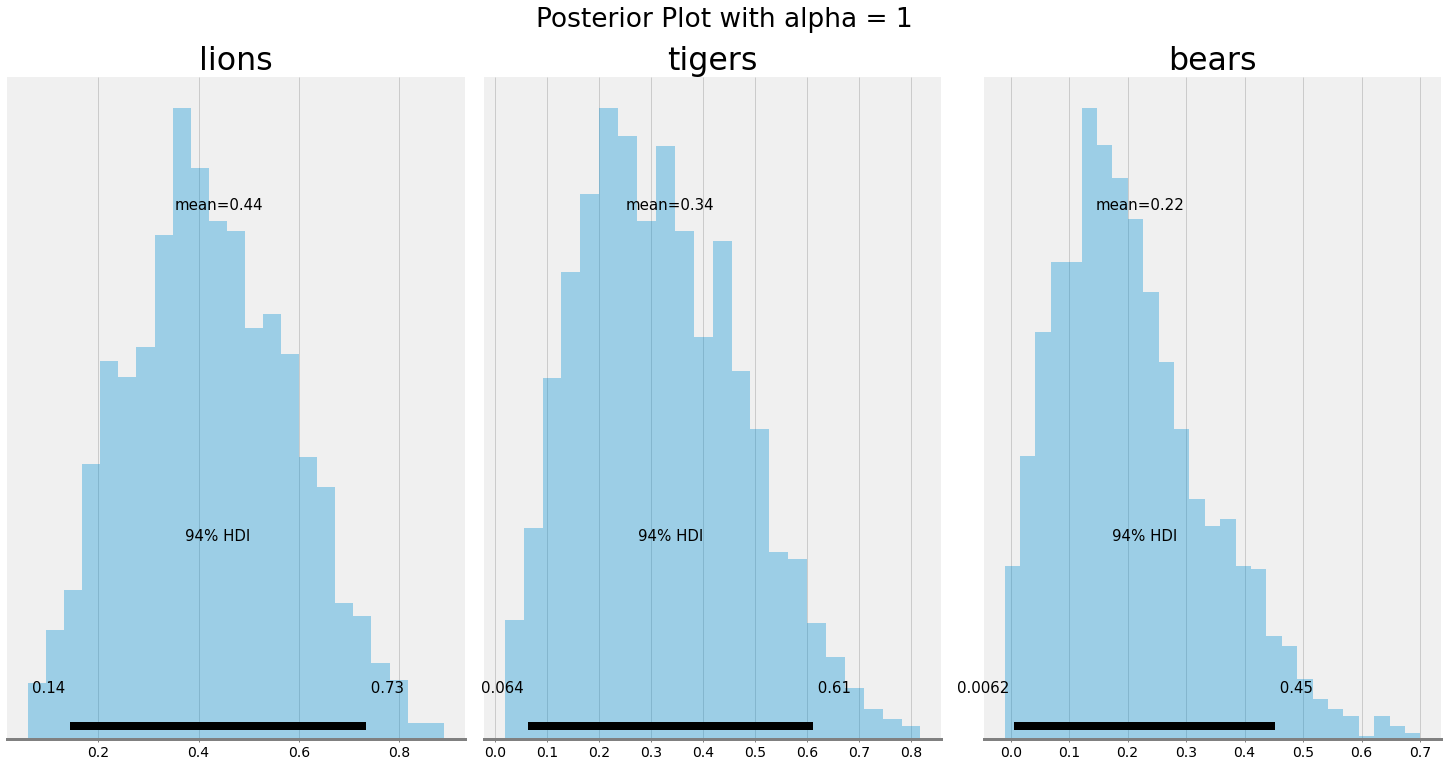

In [96]:
ax = pm.plot_posterior(trace, var_names = ["parameters"], 
                       figsize = (20, 10), kind="hist");

plt.rcParams["font.size"] = 22
for i, a in enumerate(species):
    ax[i].set_title(a);

plt.suptitle('Posterior Plot with alpha = 1', y = 1.05);